# Example `Dysmalpy` 2D fitting

In this example, we use `dysmalpy` to measure the kinematics of galaxy **GS4_43501** at $z=1.613$. This notebook shows how to find the best fit models for the two-dimensional velocity and velocity dispersion profiles using $\texttt{MPFIT}$ as well as $\texttt{MCMC}$. These fits allow us to measure quantities such as the total mass (disk+bulge), the effective radius $r_\mathrm{eff}$, dark matter fraction $f_\mathrm{DM}$ and velocity dispersion $\sigma_0$.

**The fitting includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion
 
 **The structure of the notebook is the following:**
 
 1) Setup steps
 2) Initialize galaxy, model set, instrument
 3) MPFIT fitting
 4) MCMC fitting
 5) Visualize a real MCMC example
 6) Nested sampling fitting
 7) Visualize a real Nested Sampling example

## 1) Setup steps ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import dysmalpy
from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes
from dysmalpy import observation
from dysmalpy import config

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# A check for compatibility:
import emcee
if int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle' 

**Setup notebook**

In [3]:
# Setup plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 100
mpl.rc("savefig", dpi=300)

from IPython.core.display import Image

In [4]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

**Set data, output paths**

In [5]:
# Data directory (the example data should be contained in the installation directory, so you don't need to modify the following two lines to run the example)
dir_path = os.path.abspath(fitting.__file__)
data_dir = os.sep.join(os.path.dirname(dir_path).split(os.sep)[:-1]+["tests", "test_data", ""])
# If you are going to use your own data, please set it here (data_dir = '/YOUR/DATA/PATH/')
print(data_dir)

# Where to save output files (see examples below)
#outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_2D/'
outdir = '/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_2D/'

/Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/


-------------------

**Load the function to tie the scale height to the disk effective radius**

In [6]:
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff

**Load the function to tie Mvirial to $f_{DM}(R_e)$**

In [7]:
from dysmalpy.fitting_wrappers.tied_functions import tie_lmvirial_NFW

:::{admonition} Info
Also see **fitting_wrappers.tied_functions** for more tied functions
:::

----------

## 2) Initialize galaxy, model set, instrument

In [8]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()

### Baryonic component: Combined Disk+Bulge

In [9]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [10]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [11]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof', tracer='halpha')

### z-height profile

In [12]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [13]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center
vel_shift = 0 # velocity shift at center ; km/s
geom_fixed = {'inc': False,
              'pa': False,
              'xshift': False,
              'yshift': False,
              'vel_shift': False}

geom_bounds = {'inc': (52, 72),
               'pa': (132, 152),
               'xshift': (-2.5, 2.5),
               'yshift': (-2.5, 2.5),
               'vel_shift': (-100, 100)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift, vel_shift=vel_shift, 
                       fixed=geom_fixed, bounds=geom_bounds, 
                       name='geom', obs_name='halpha_2D')

geom.inc.prior = parameters.BoundedSineGaussianPrior(center=62, stddev=0.1)

### Add all model components to ModelSet

In [14]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [15]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the observation and instrument

In [16]:
obs = observation.Observation(name='halpha_2D', tracer='halpha')
inst = instrument.Instrument()

beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [27, 27]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

# Extraction information
inst.ndim = 2                            # Dimensionality of data
inst.moment = False                      # For 1D/2D data, if True then velocities and dispersion calculated from moments
                                         # Default is False, meaning Gaussian extraction used
    
# Add instrument to observation
obs.instrument = inst

### Load data

* Load the data from file:
  - *2D velocity, dispersion maps and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data2D` class

* Add data to Galaxy object

In [17]:
gal_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm.fits')
gal_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm.fits')

err_vel = fits.getdata(data_dir+'GS4_43501_Ha_vm_err.fits')
err_disp = fits.getdata(data_dir+'GS4_43501_Ha_dm_err.fits')

mask = fits.getdata(data_dir+'GS4_43501_Ha_m.fits')

#gal_disp[(gal_disp > 1000.) | (~np.isfinite(gal_disp))] = -1e6
#mask[(gs4_disp < 0)] = 0

inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution

# Mask NaNs:
mask[~np.isfinite(gal_vel)] = 0
gal_vel[~np.isfinite(gal_vel)] = 0.

mask[~np.isfinite(err_vel)] = 0
err_vel[~np.isfinite(err_vel)] = 0.

mask[~np.isfinite(gal_disp)] = 0
gal_disp[~np.isfinite(gal_disp)] = 0.

mask[~np.isfinite(err_disp)] = 0
err_disp[~np.isfinite(err_disp)] = 0.
    

# Put data in Data2D data class: 
#    ** specifies data pixscale as well **
data2d = data_classes.Data2D(pixscale=inst.pixscale.value, velocity=gal_vel,
                                  vel_disp=gal_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, mask=mask, 
                                  inst_corr=inst_corr)

# Use moment for extraction for example: 
#     Not how data was extracted, but it's a speedup for this example. 
#     
#     The best practic option, if the 2D maps are extracted with gaussians, 
#     is to compile the C++ extensions and pass the option 'gauss_extract_with_c=True'
#     when running fitting.fit_mpfit()
data2d.moment = True

# Add data to Observation:
obs.data = copy.deepcopy(data2d)

### Define model, fit options:

In [18]:
obs.mod_options.oversample = 1  
# Factor by which to oversample model (eg, subpixels)
# For increased precision, oversample=3 is suggested. 

obs.fit_options.fit = True             # Include this observation in the fit (T/F)
obs.fit_options.fit_velocity = True    # 1D/2D: Fit velocity of observation (T/F)
obs.fit_options.fit_dispersion = True  # 1D/2D: Fit dispersion of observation (T/F)
obs.fit_options.fit_flux = False       # 1D/2D: Fit flux of observation (T/F)

### Add the model set, observation to the Galaxy

In [19]:
gal.model = mod_set
gal.add_observation(obs)

-----------------

## 3) MPFIT Fitting

**Set up ``MPFITFitter`` fitter with fitting parameters**

In [20]:
# Options passed to MPFIT:
maxiter = 200

fitter = fitting.MPFITFitter(maxiter=maxiter)

**Set up fit/plot output options**

In [21]:
# Output directory
outdir_mpfit = outdir+'MPFIT/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mpfit, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MPFIT**

In [22]:
mpfit_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:    obs: halpha_2D
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:    mvirial_tied: <function tie_lmvirial_NFW at 0x176a55da0>
INFO:DysmalPy:
MPFIT Fitting:
Start: 2024-05-02 10:47:55.313966

INFO:DysmalPy:Iter 1  CHI-SQUARE = 27260.87785  DOF = 403
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  
   geom:inc = 62  
   geom:pa = 142  
   geom:xshift = 0  
   geom:yshift = 0  
   geom:vel_shift = 0  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 7174.918633  DOF = 403
   disk+bulge:total_mass = 11.01621875  
   disk+bulge:r_eff_disk = 5.697081099  
   halo:fdm = 0.290454085  
   dispprof:sigma0 = 41.78914475  
   geom:inc = 72  
   geom:pa = 142.4487865  
   geom:xshift = 0.01555573571  
   geom:yshift = -0.01483259239  
   geom:vel_shift = 0.688311908  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 4845.547462  DOF = 403
   disk+bulg

### Examine MPFIT results

#### Result plots

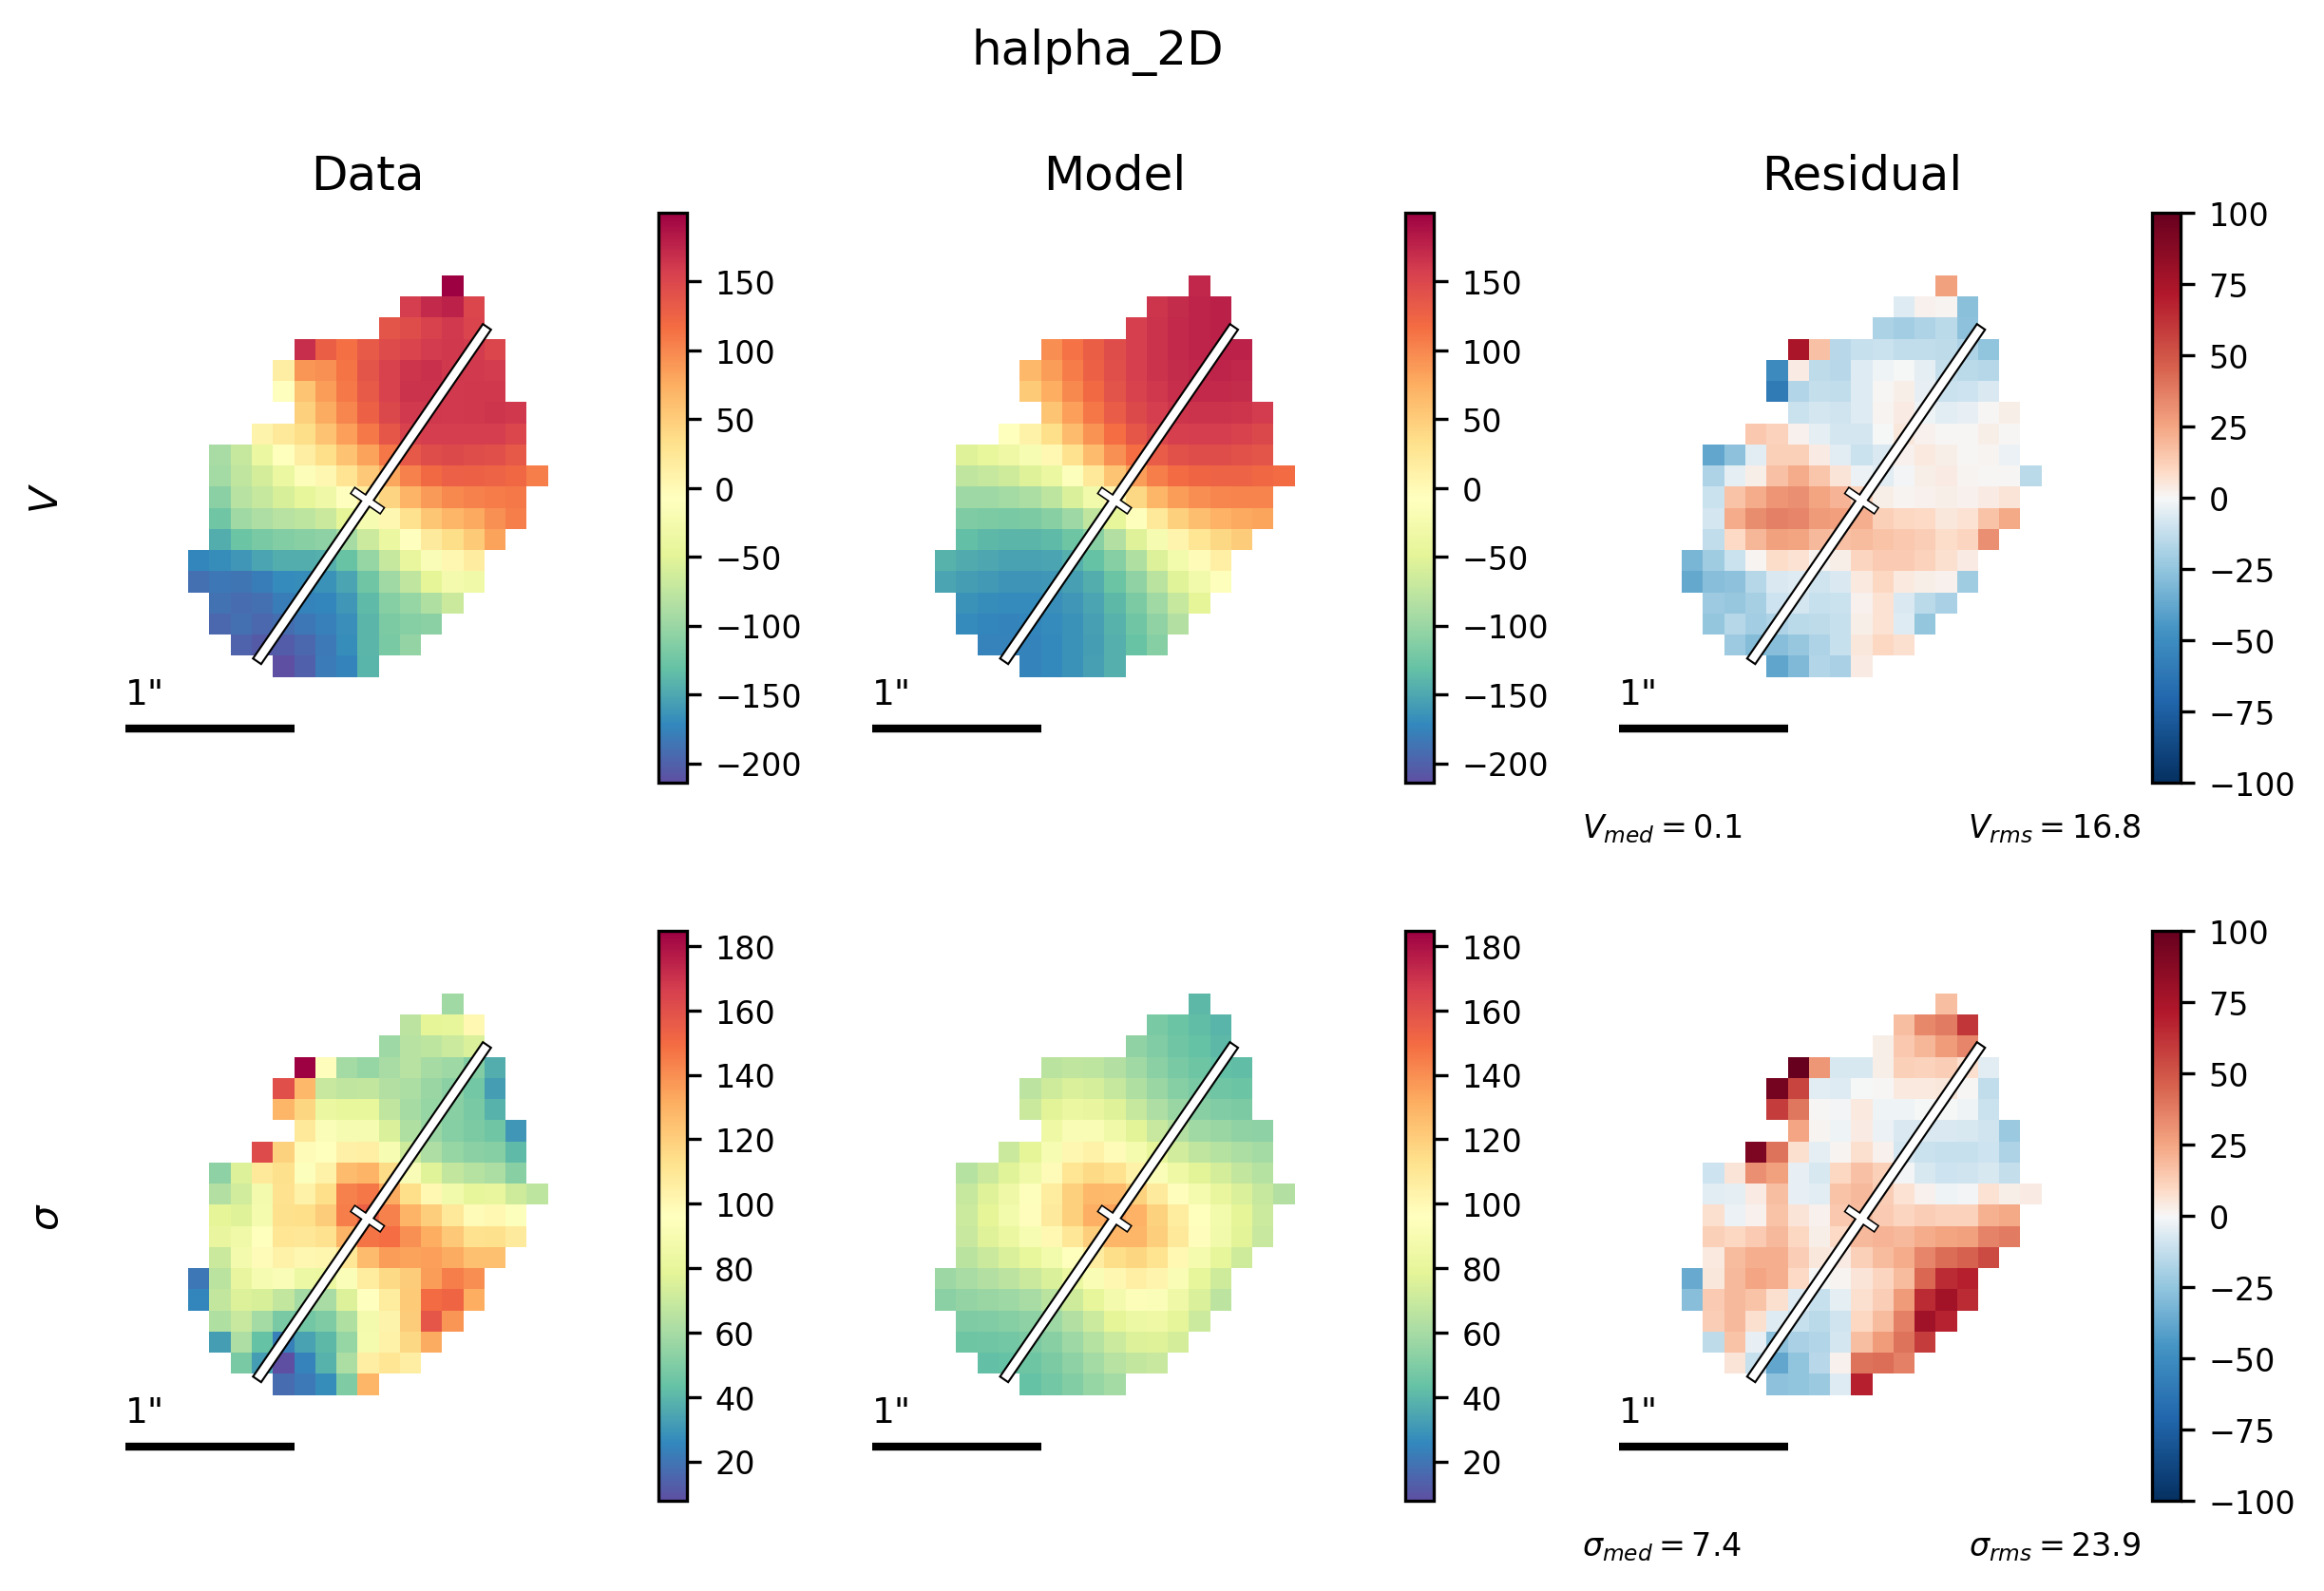

In [23]:
# Look at best-fit:
filepath = outdir_mpfit+"GS4_43501_mpfit_bestfit_halpha_2D.{}".format(plot_type)
Image(filename=filepath, width=600)

#### Directly generating result plots ####

**Reload the galaxy, results files:**

In [24]:
f_galmodel =       outdir_mpfit + 'GS4_43501_model.pickle'
f_mpfit_results =  outdir_mpfit + 'GS4_43501_mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results, fit_method='mpfit')

**Plot the best-fit results:**

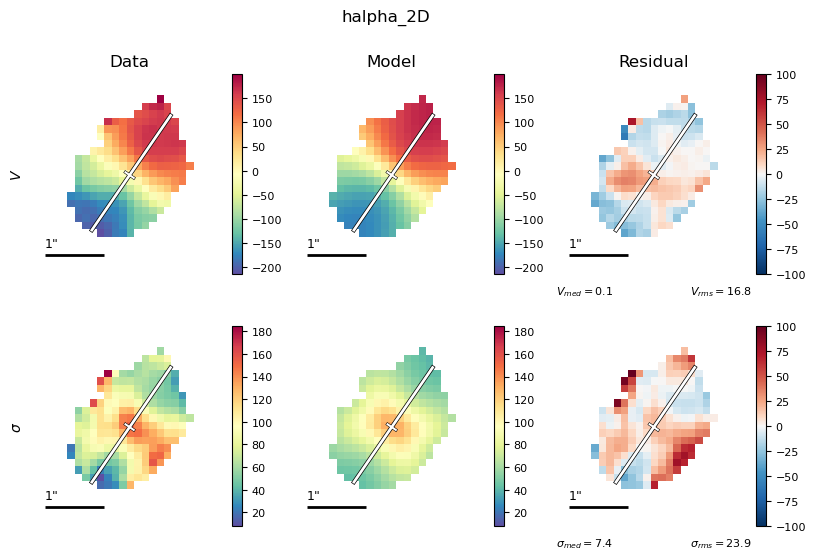

In [25]:
mpfit_results.plot_results(gal)

#### Result reports

We now look at the results reports, which include the best-fit values and uncertainties (as well as other fitting settings and output).

In [26]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2024-05-02 10:48:08.695418

    obs: halpha_2D
         Datafiles:
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MPFIT
    fit status: 2

pressure_support:      True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass         11.2710  +/-   0.0105
    r_eff_disk         12.1632  +/-   0.3596

    n_disk              1.0000  [FIXED]
    r_eff_bulge         1.0000  [FIXED]
    n_bulge             4.0000  [FIXED]
    bt                  0.3000  [FIXED]
    mass_to_light       1.0000  [FIXED]

    noord_flat          True
-----------
 halo
    fdm                 0.0684  +/-   0.0017

    mvirial            10.3144  [TIED]
    conc                5.0

**To <span style="color:DarkCyan">directly save</span> the results report** to a file, we can use the following:

(Note: by default, report files are saved as part of the fitting process)

In [27]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## 4) MCMC Fitting

**Get a clean copy of model, obs**

In [28]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')

obscopy = observation.Observation(name='halpha_2D', tracer='halpha')
obscopy.data = copy.deepcopy(data2d)
obscopy.instrument = copy.deepcopy(inst)
obscopy.mod_options = copy.deepcopy(obs.mod_options)
obscopy.fit_options = copy.deepcopy(obs.fit_options)

gal.add_observation(obscopy)

gal.model = copy.deepcopy(mod_set)

**Set up ``MCMCFitter`` fitter with fitting parameters**

In [29]:
# Options passed to emcee
## SHORT TEST:
nWalkers = 20
nCPUs = 4
scale_param_a = 5 #3   
# The walkers were not exploring the parameter space well with scale_param_a = 3, 
#     but were getting 'stuck'. So to improve the walker movement with larger 
#     'stretch' in the steps, we increased scale_param_a.
nBurn = 2
nSteps = 5
minAF = None
maxAF = None
nEff = 10

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step


fitter = fitting.MCMCFitter(nWalkers=nWalkers, nCPUs=nCPUs, 
                            scale_param_a=scale_param_a, nBurn=nBurn, nSteps=nSteps, 
                            minAF=minAF, maxAF=maxAF, nEff=nEff, blob_name=blob_name)

**Set up fit/plot output options**

In [30]:
# Output directory
outdir_mcmc = outdir + 'MCMC/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mcmc, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MCMC**

In [31]:
mcmc_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:    obs: halpha_2D
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 20
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x176a55da0>
INFO:DysmalPy:
Burn-in:
Start: 2024-05-02 10:48:08.778789

INFO:DysmalPy: k=0, time.time=2024-05-02 10:48:08.779474, a_frac=nan


INFO:DysmalPy: k=1, time.time=2024-05-02 10:48:09.729780, a_frac=0.25
INFO:DysmalPy:
End: 2024-05-02 10:48:10.247523

******************
nCPU, nParam, nWalker, nBurn = 4, 9, 20, 2
Scale param a= 5
Time= 1.47 (sec),   0:1.47 (m:s)
Mean acceptance fraction: 0.225
Ideal acceptance frac: 0.2 - 0.5
Autocorr est: [nan nan nan nan nan nan nan nan nan]
******************
INFO:DysmalPy:
Ensemble sampling:
Start: 2024-05-02 10:48:10.973361

INFO:DysmalPy:ii=0, a_frac=0.2 time.time()=2024-05-02 10:48:11.308325
INFO:DysmalPy:0: acor_time =[nan nan nan nan nan nan nan nan nan]
INFO:DysmalPy:ii=1, a_frac=0.175 time.time()=2024-05-02 10:48:11.514939
INFO:DysmalPy:1: acor_time =[nan nan nan nan nan nan nan nan nan]
INFO:DysmalPy:ii=2, a_frac=0.18333333333333335 time.time()=2024-05-02 10:48:12.045867
INFO:DysmalPy:2: acor_time =[nan nan nan nan nan nan nan nan nan]
INFO:DysmalPy:ii=3, a_frac=0.2125 time.time()=2024-05-02 10:48:12.293471
INFO:DysmalPy:3: acor_time =[nan nan nan nan nan nan nan nan nan]


### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

**Trace**
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

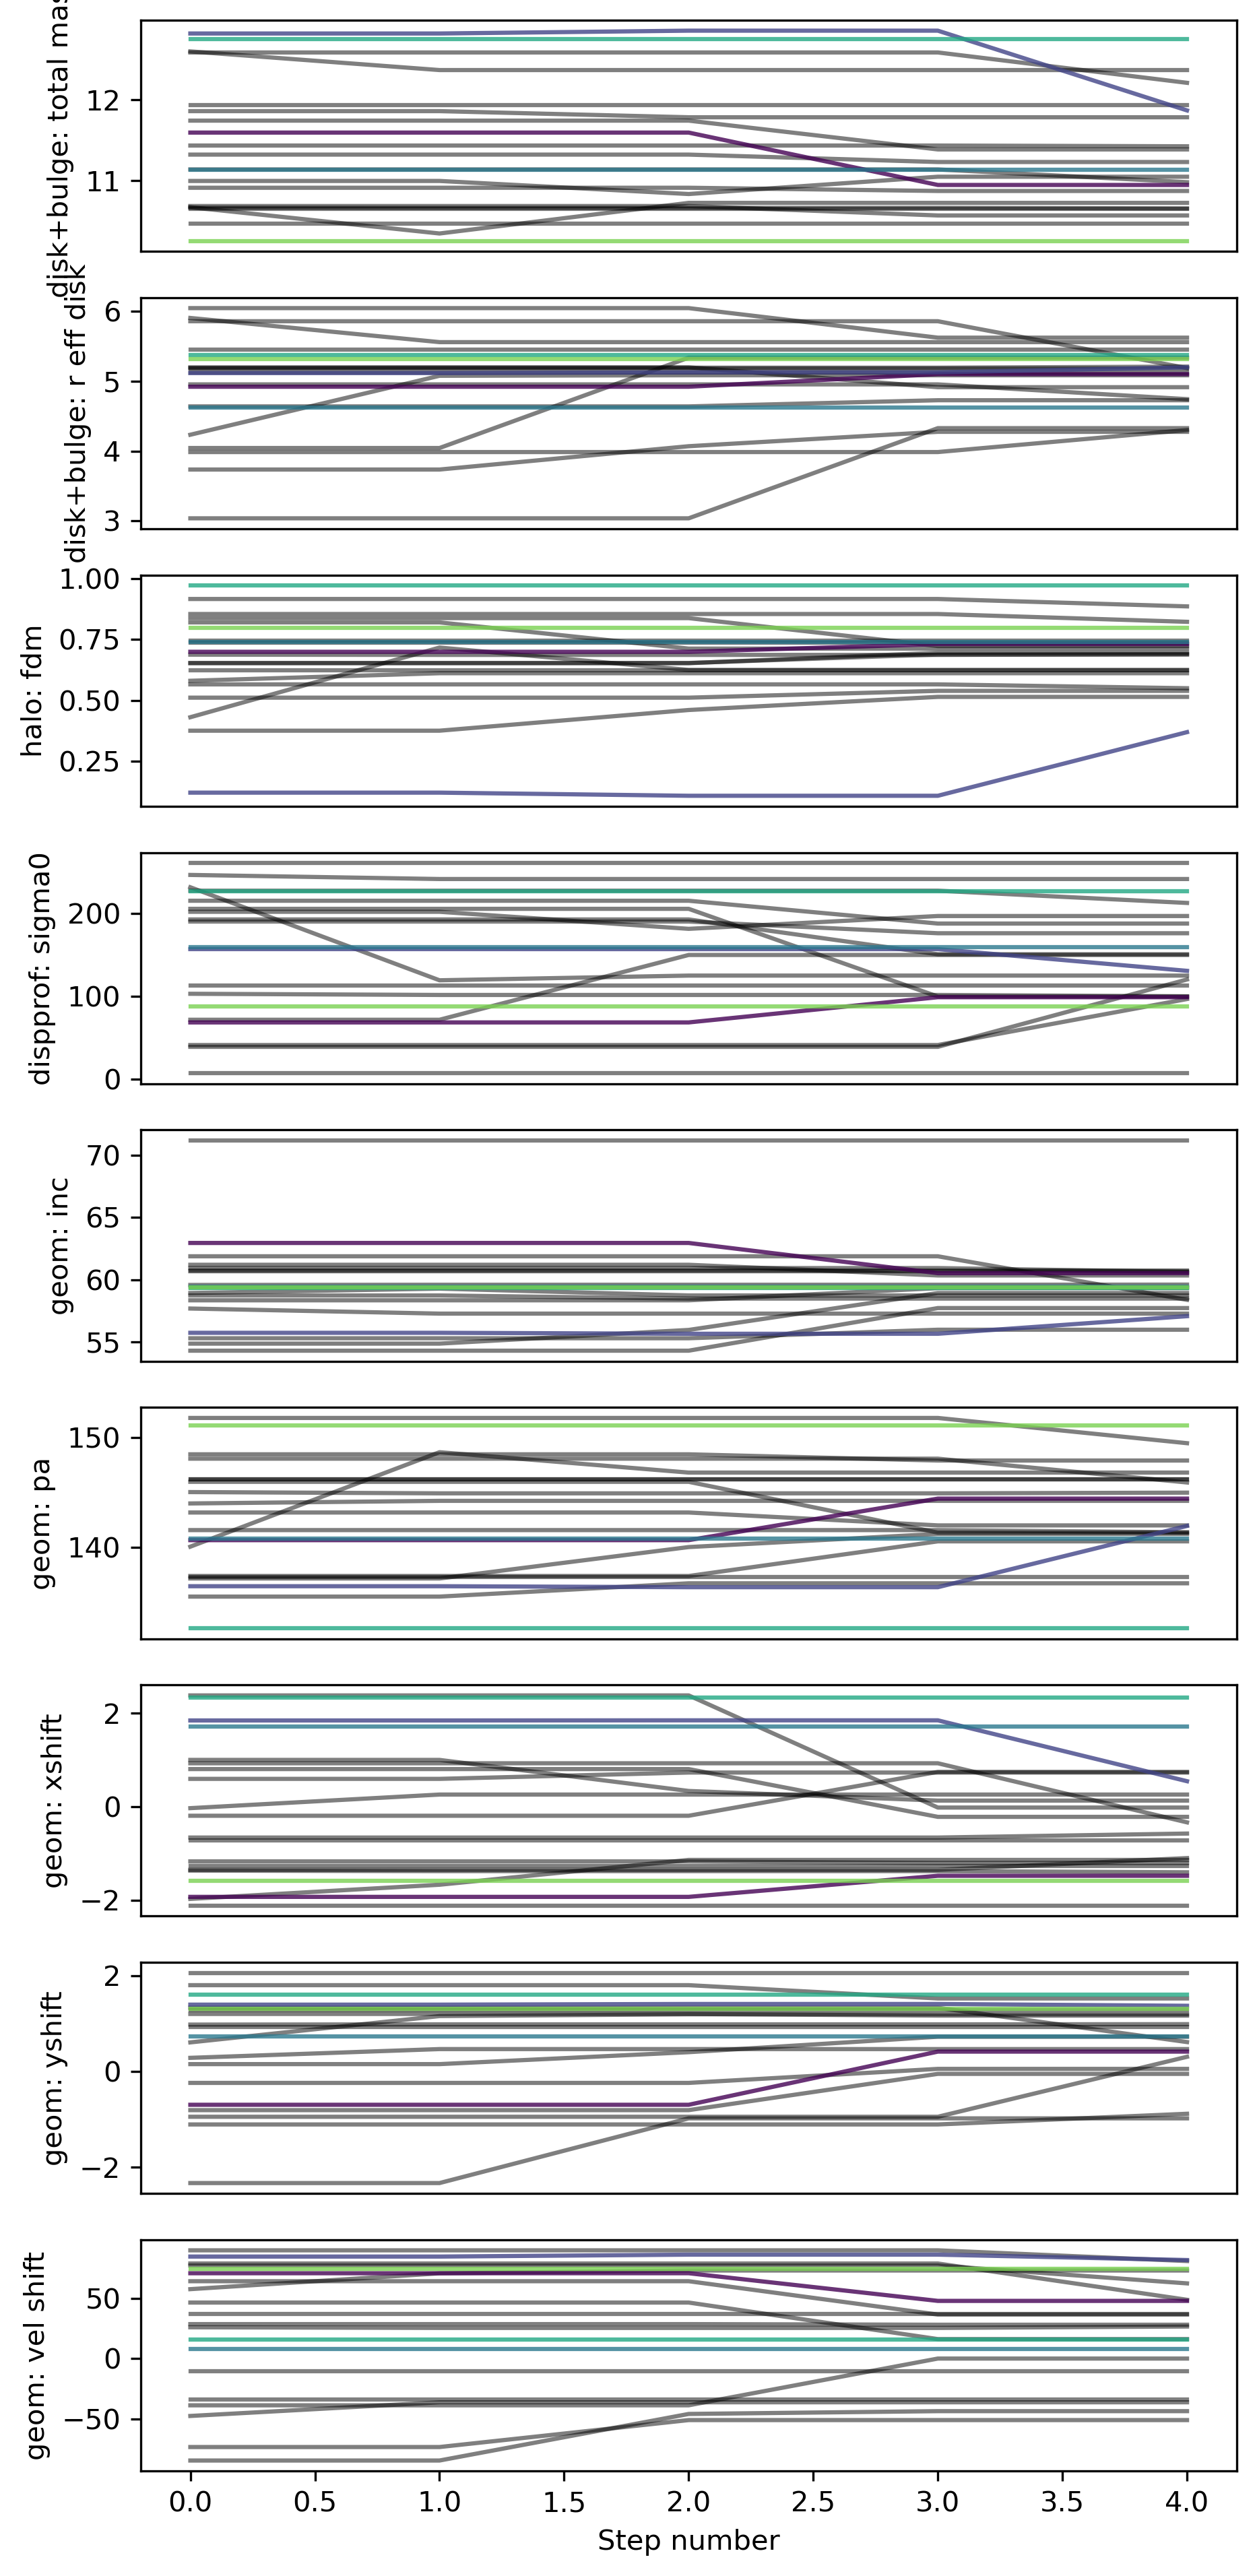

In [32]:
# Look at trace:
filepath = outdir_mcmc+"GS4_43501_mcmc_trace.{}".format(plot_type)
Image(filepath, width=600)

**Best-fit**
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!
- Also, it's helpful to check that your data masking is reasonable.
- Finally, this is a worthwhile chance to see if your "nuisance" geometry and spectral parameters (especially `xshift`, `yshift`, `vel_shift` have reasonable values, and if appropriate, reasonable bounds and priors.)

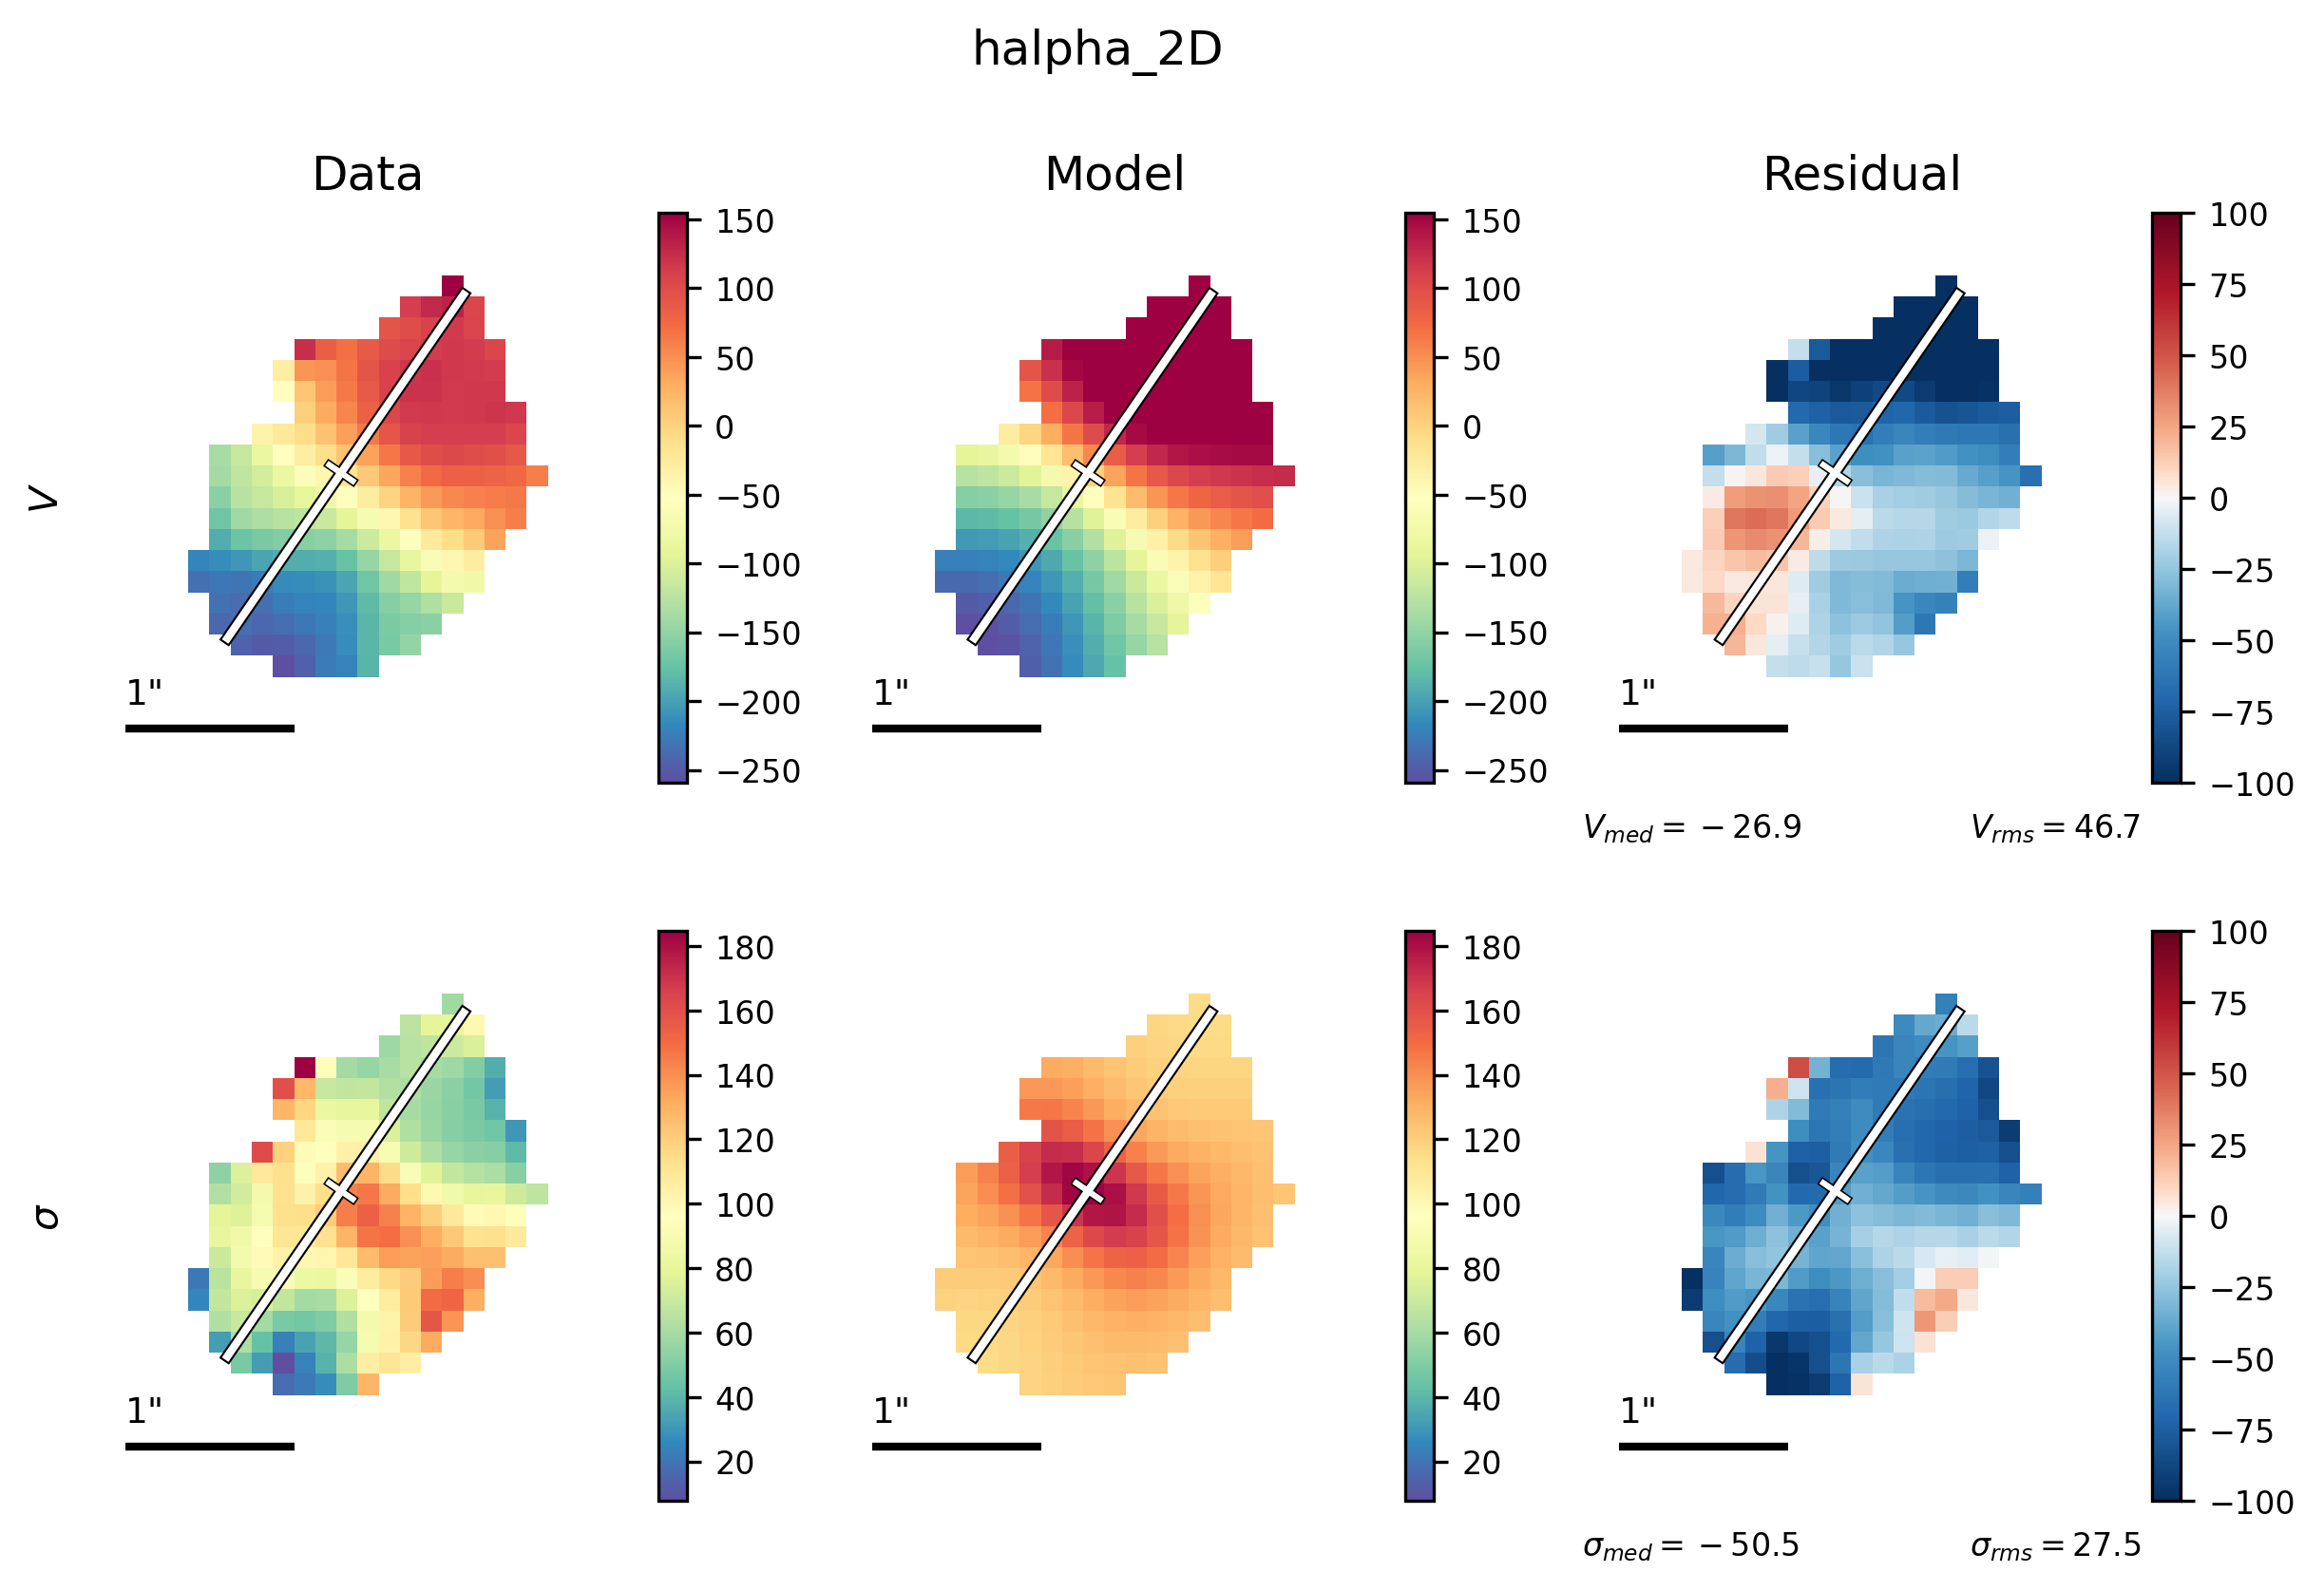

In [33]:
# Look at best-fit:
filepath = outdir_mcmc+"GS4_43501_mcmc_bestfit_halpha_2D.{}".format(plot_type)
Image(filepath, width=600)

**Sampler "corner" plot**
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space. <p>
       *(&rarr; see the example in the :ref:`1D example fit <dysmalpy_example_fit_1D.ipynb>` tutorial)*
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

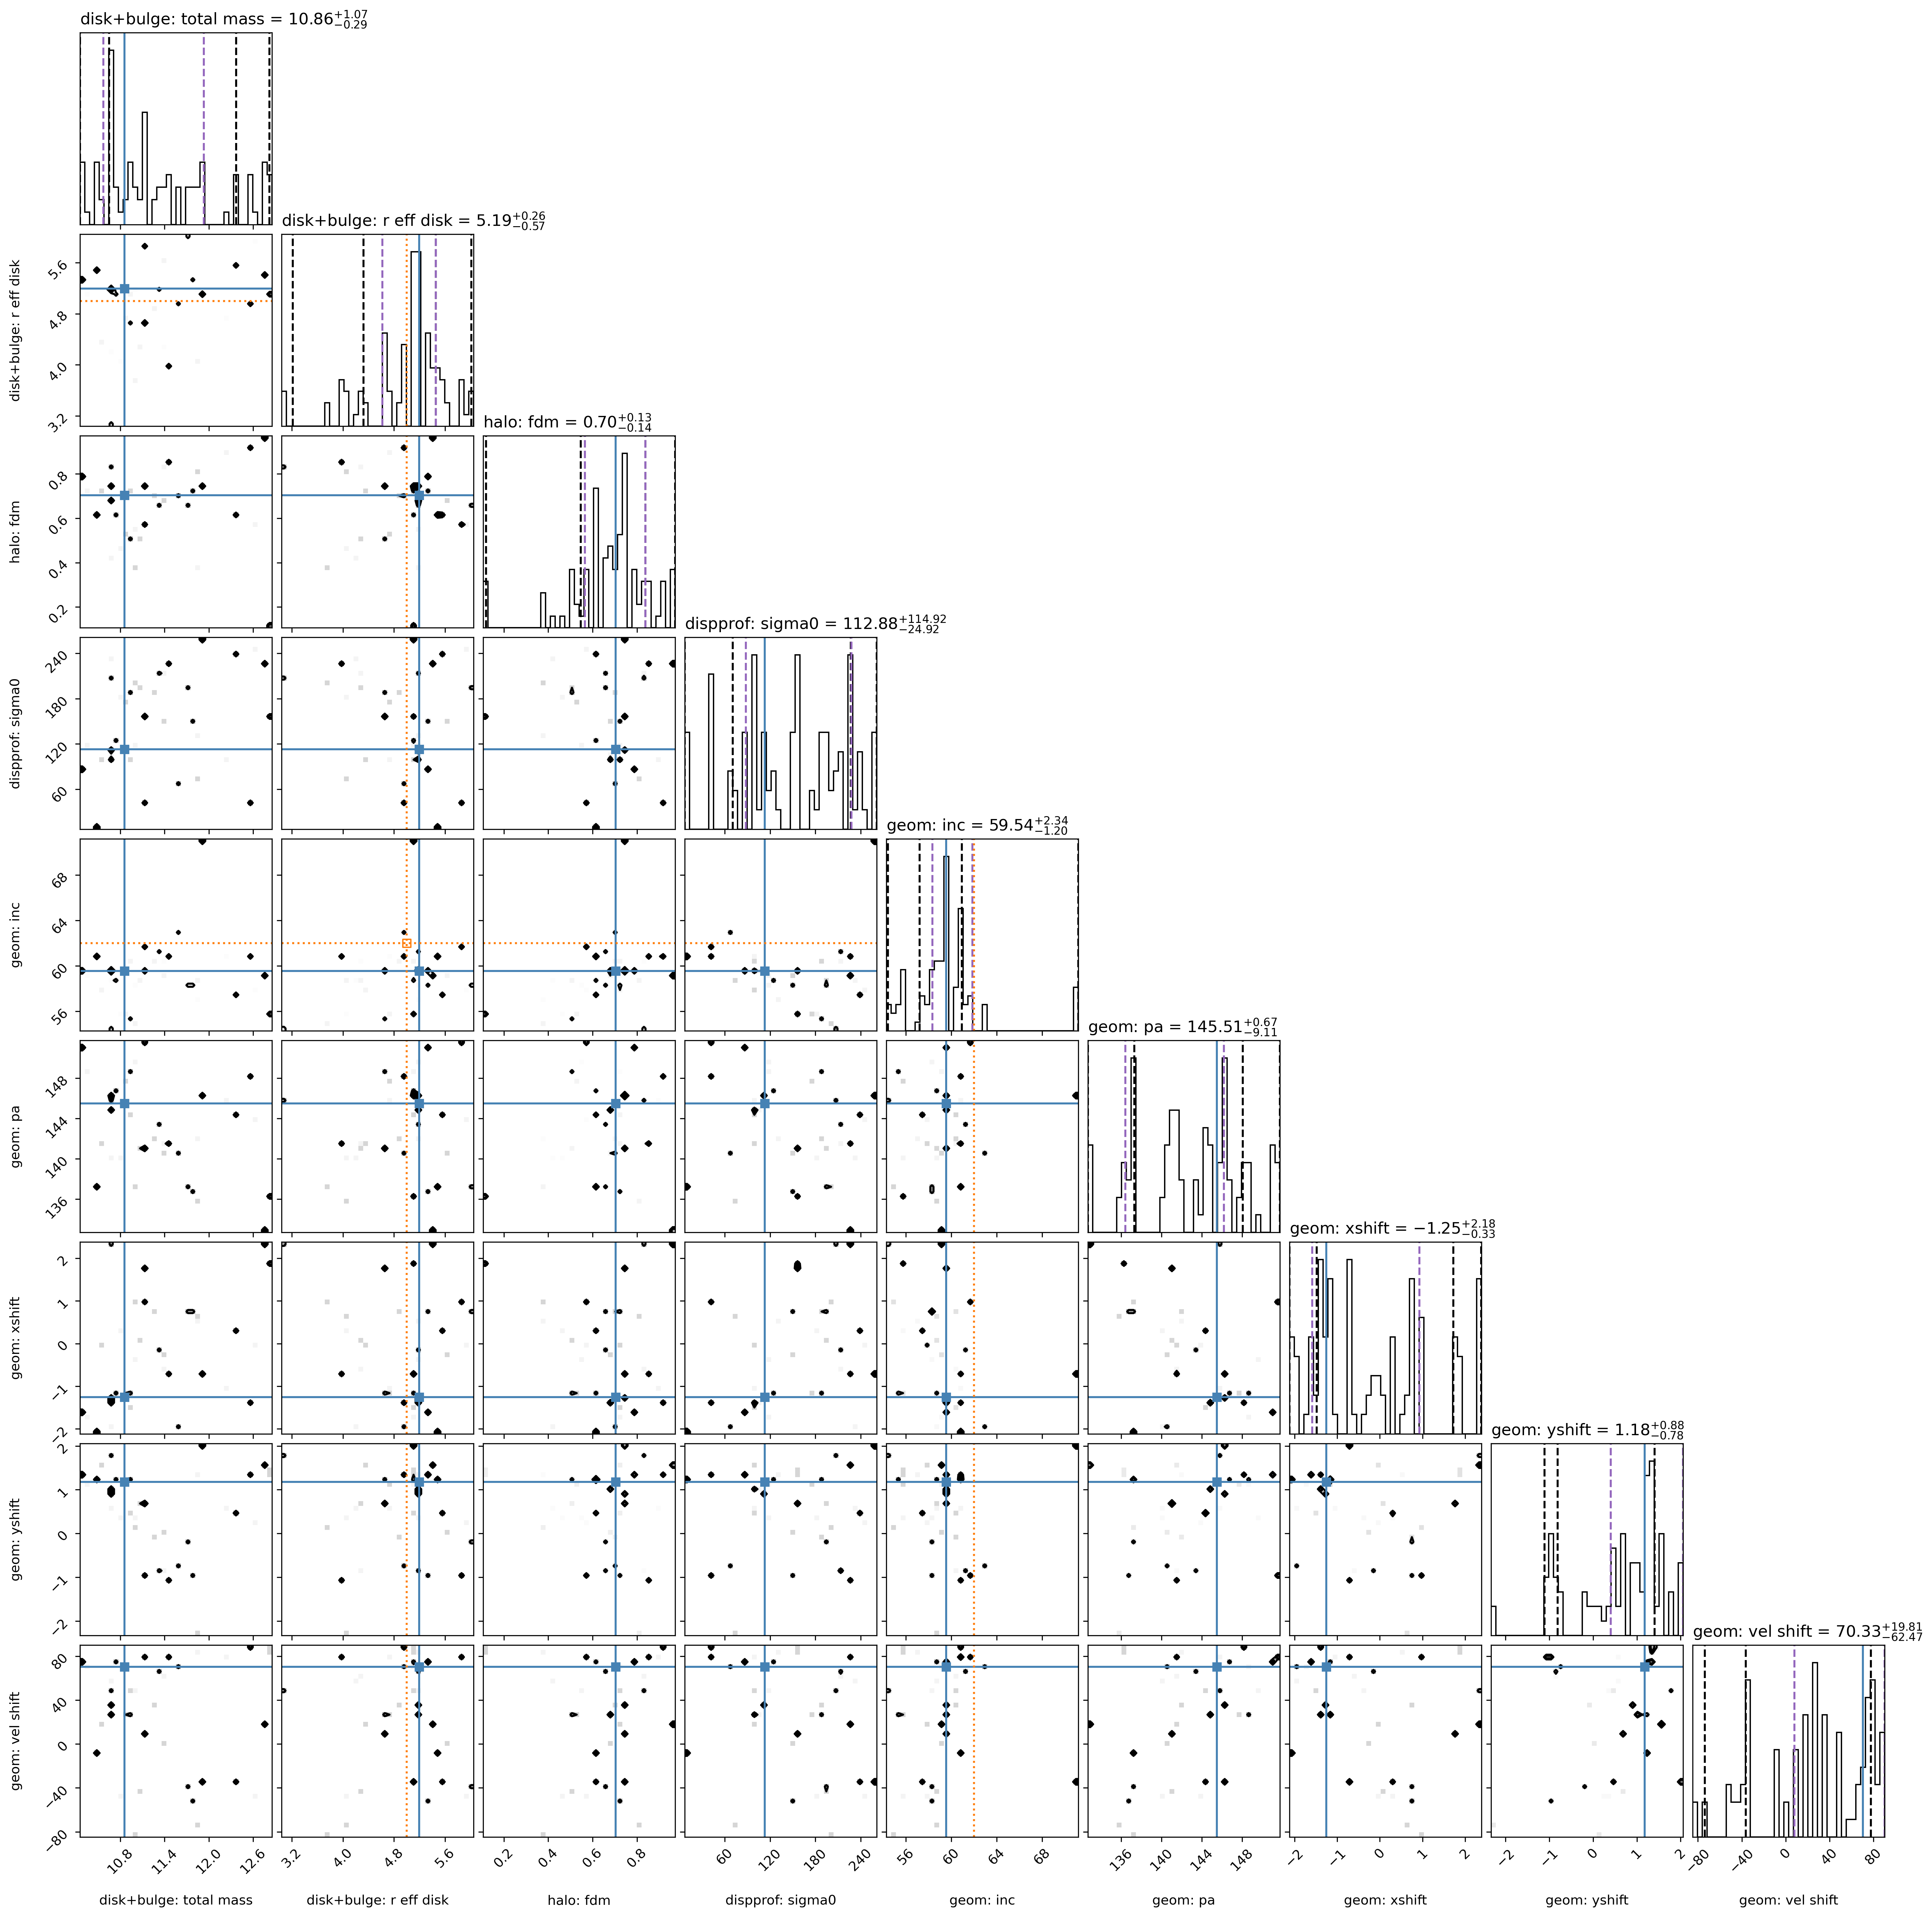

In [34]:
# Look at corner:
filepath = outdir_mcmc+"GS4_43501_mcmc_param_corner.{}".format(plot_type)
Image(filepath, height=620)

---------

## 5) Visualize a real MCMC example ##

In the interest of time, let's look at some results calculated previously, using 1000 walkers, 175 burn-in steps, and 200 steps. 

Using **190 threads**, it took about **21 minutes** to run the MCMC fit.

First, you need to download the sampler from:

https://www.mpe.mpg.de/resources/IR/DYSMALPY/dysmalpy_optional_extra_files/JUPYTER_OUTPUT_2D.tar.gz

Decompress it in your preferred path (e.g.: /path/to/your/directory) and then set an environment variable to access that directory from this notebook. You can do that from the terminal running:

*export DATADIR=/path/to/your/directory*

Or, you can simply run the bash command from within the notebook as:

*%env FULL_MCMC_RUNS_DATADIR=/path/to/your/directory*

In [35]:
# A working example using the path of one of the maintainers:
%env FULL_MCMC_RUNS_DATADIR=/Users/jespejo/Dropbox/dysmalpy_example_files/JUPYTER_OUTPUT_2D/

env: FULL_MCMC_RUNS_DATADIR=/Users/jespejo/Dropbox/dysmalpy_example_files/JUPYTER_OUTPUT_2D/


In [36]:
# Now, add the environment variable to retrieve the data 
_full_mcmc_runs = os.getenv('FULL_MCMC_RUNS_DATADIR')

:::{admonition} Note
We used moment extraction for the model 2D profile extraction, as this 
does not seem to change the result much compared to gaussian extraction 
(as the observed maps were derived). This is likely because the extraction 
is over single pixels, so there is less complex line shape mixing 
as found in 1D extractions.

If this fit is done using a gaussian extraction, exactly following 
the data extraction method, it is generally slower.

When performing fits using moment extraction on data that was gaussian extracted, 
it is worth considering whether this is a reasonable thing to be doing. 
(Or at least check the final results with a gaussian extraction to see if there 
are systematic differences between the moment and gaussian maps.)
:::

In [37]:
outdir_mcmc_full = _full_mcmc_runs + '/MCMC_full_run_nw1000_ns200_a5/'

### Examine results: ###

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)

**Reload the galaxy, results files:**

In [38]:
f_galmodel = outdir_mcmc_full + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'mcmc_results.pickle'

#----------------------------------------
## Fix module import
import sys
from dysmalpy import fitting_wrappers
sys.modules['fitting_wrappers'] = fitting_wrappers
#----------------------------------------


if os.path.isfile(f_galmodel) & os.path.isfile(f_mcmc_results):
    gal_full, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                                filename_results=f_mcmc_results, fit_method='mcmc')
else:
    gal_full = mcmc_results = None

**If necessary, also reload the sampler chain:**

In [39]:
f_sampler =  outdir_mcmc_full + 'mcmc_sampler.{}'.format(ftype_sampler)
if os.path.isfile(f_sampler) & (mcmc_results is not None):
    mcmc_results.reload_sampler_results(filename=f_sampler)

N/10 = 20;
tau: [19.6537326  19.9891195  19.55235249 19.98314067 19.7486466  19.41789169
 19.19654616 20.31377879 19.68237055]


**Plot the best-fit results:**

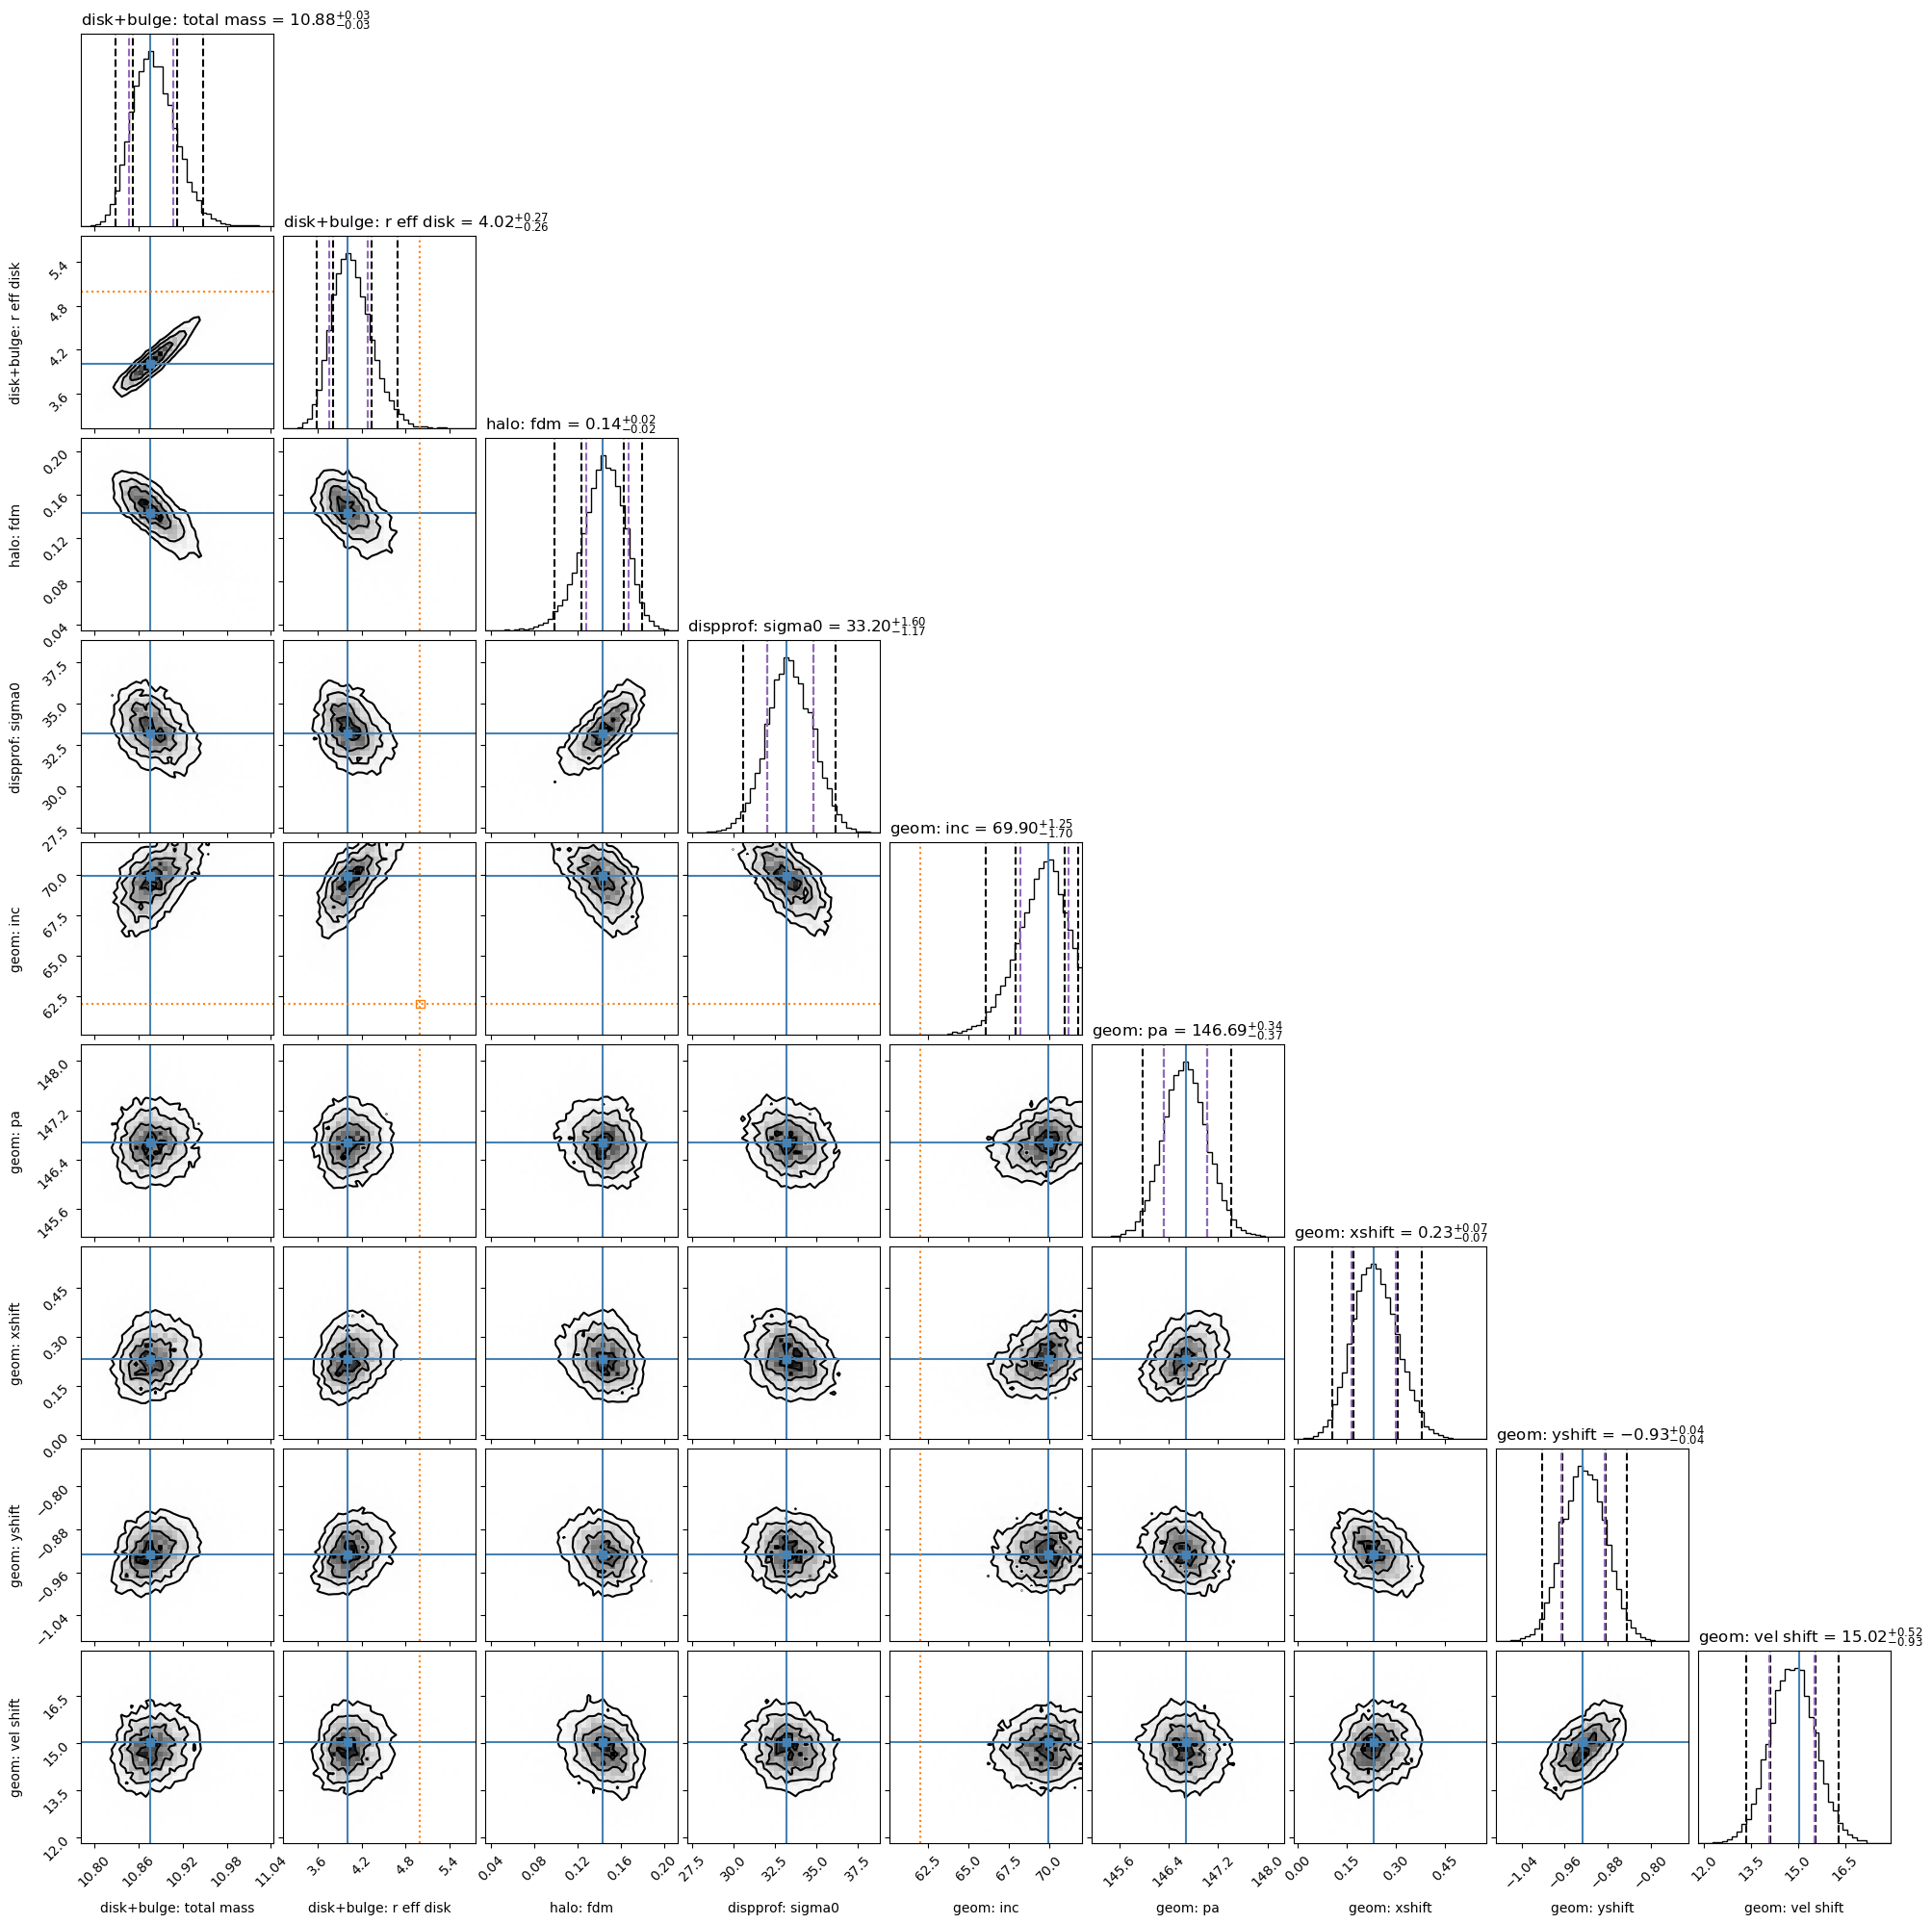

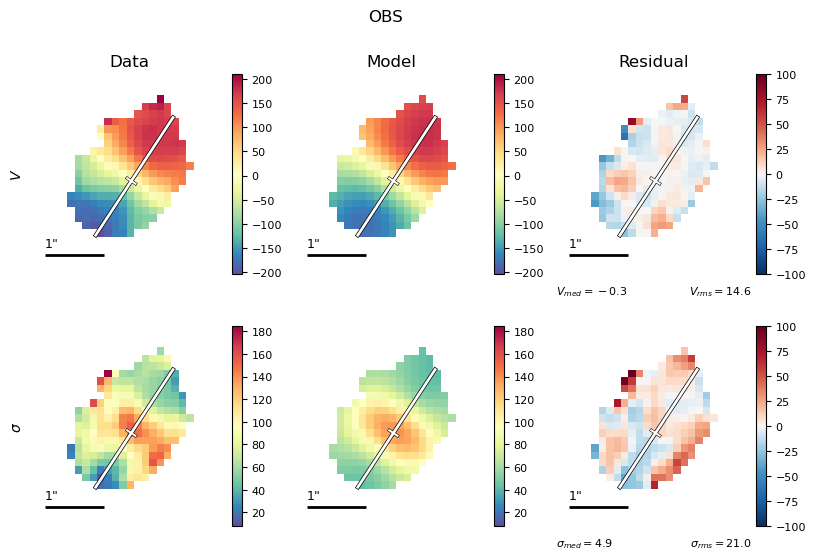

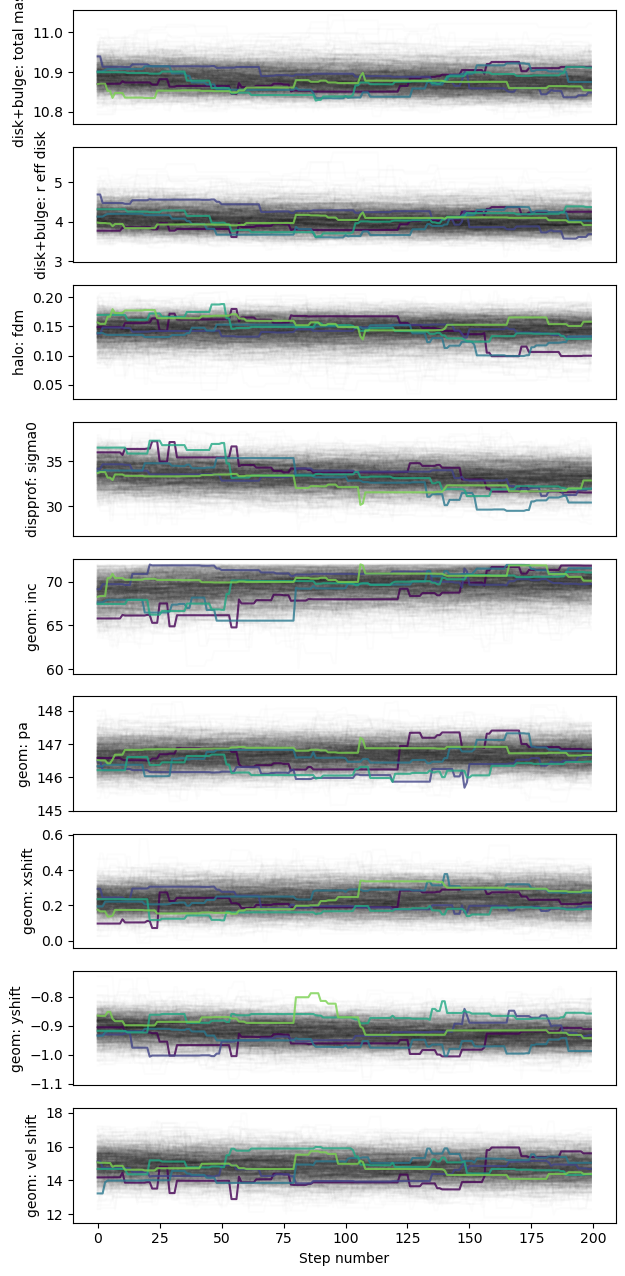

In [40]:
if (gal_full is not None) & (mcmc_results is not None):
    mcmc_results.plot_results(gal_full)

#### Results report: ####

In [41]:
# Print report
if (gal_full is not None) & (mcmc_results is not None):
    print(mcmc_results.results_report(gal=gal_full))

###############################
 Fitting for GS4_43501

Date: 2024-05-02 10:48:21.959682

    obs: OBS
         Datafiles:
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           True
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MCMC

pressure_support:      True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass         10.8755  -   0.0278 +   0.0312
    r_eff_disk          4.0151  -   0.2608 +   0.2707

    n_disk              1.0000  [FIXED]
    r_eff_bulge         1.0000  [FIXED]
    n_bulge             4.0000  [FIXED]
    bt                  0.3000  [FIXED]

    noord_flat          True
-----------
 halo
    fdm                 0.1433  -   0.0150 +   0.0242

    mvirial            11.4323  [TIED]
    conc                5.0000  [FIXED]
-----------
 dispprof
    

**Or save results report to file:**

In [42]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
if (gal_full is not None) & (mcmc_results is not None):
    mcmc_results.results_report(gal=gal_full, filename=f_mcmc_report)